# 0. Configuration

In [ ]:
# links to shared data MovieLens
# source on kaggle: https://www.kaggle.com/code/quangnhatbui/movie-recommender/data
MOVIES_METADATA_URL = 'https://drive.google.com/file/d/19g6-apYbZb5D-wRj4L7aYKhxS-fDM4Fb/view?usp=share_link'

# 1. Modules and functions

In [ ]:
!pip install --upgrade gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import re
import nltk
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from ast import literal_eval
from pymystem3 import Mystem
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import warnings
warnings.filterwarnings('ignore')

# download stop words beforehand
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1.1. Helper functions to avoid copypaste

In [ ]:
def read_csv_from_gdrive(url):
    """
    gets csv data from a given url (taken from file -> share -> copy link)
    :url: example https://drive.google.com/file/d/1BlZfCLLs5A13tbNSJZ1GPkHLWQOnPlE4/view?usp=share_link
    """
    file_id = url.split('/')[-2]
    file_path = 'https://drive.google.com/uc?export=download&id=' + file_id
    data = pd.read_csv(file_path)

    return data

In [ ]:
# init lemmatizer to avoid slow performance
mystem = Mystem() 

def word_tokenize_clean(doc: str, stop_words: list):
    '''
    tokenize from string to list of words
    '''

    # split into lower case word tokens \w lemmatization
    tokens = list(set(mystem.lemmatize(doc.lower())))
  
    # remove tokens that are not alphabetic (including punctuation) and not a stop word
    tokens = [word for word in tokens if word.isalpha() and not word in stop_words \
              not in list(punctuation)]
    return tokens

# 2. Main

## 2.1. Data Preparation

In [ ]:
# read csv information about films etc
movies_metadata = read_csv_from_gdrive(MOVIES_METADATA_URL)
movies_metadata.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


In [ ]:
# let's see what columns we have
movies_metadata.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

To get accurate results we need to preprocess text a bit. The pipeline will be as follows:

- Filter only necessary columns from movies_metadada : id, original_title, overview;
- Define `model_index` for model to match back with `id` column;
- Text cleaning: removing stopwords & punctuation, lemmatization for further tokenization and tagged document creatin required for gensim.Doc2Vec

In [ ]:
# filter cols
sample = movies_metadata[['id', 'original_title', 'overview', 'original_language', 'adult', 'popularity']].copy()
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 45466 non-null  object
 1   original_title     45466 non-null  object
 2   overview           44512 non-null  object
 3   original_language  45455 non-null  object
 4   adult              45466 non-null  object
 5   popularity         45461 non-null  object
dtypes: object(6)
memory usage: 2.1+ MB


In [ ]:
# as you see from above, we have missing overview in some cases -- let's fill it with the original title
sample.loc[sample['overview'].isnull(), 'overview'] = sample.loc[sample['overview'].isnull(), 'original_title']
sample.isnull().sum()

id                    0
original_title        0
overview              0
original_language    11
adult                 0
popularity            5
dtype: int64

In [ ]:
# define model_index and make it as string
sample = sample.reset_index().rename(columns = {'index': 'model_index'})
sample['model_index'] = sample['model_index'].astype(str)

In [ ]:
sample

,model_index,id,original_title,overview,original_language,adult,popularity
0,0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...",en,False,21.946943
1,1,8844,Jumanji,When siblings Judy and Peter discover an encha...,en,False,17.015539
2,2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...,en,False,11.7129
3,3,31357,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",en,False,3.859495
4,4,11862,Father of the Bride Part II,Just when George Banks has recovered from his ...,en,False,8.387519
...,...,...,...,...,...,...,...
45461,45461,439050,رگ خواب,Rising and falling between a man and woman.,fa,False,0.072051
45462,45462,111109,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,tl,False,0.178241
45463,45463,67758,Betrayal,"When one of her hits goes wrong, a professiona...",en,False,0.903007
45464,45464,227506,Satana likuyushchiy,"In a small town live two brothers, one a minis...",en,False,0.003503


In [ ]:
# create mapper with title and model_idnex to use it further in evaluation
movies_inv_mapper = dict(zip(sample['original_title'].str.lower(), sample['model_index'].astype(int)))

In [ ]:
tags = np.array([str(i) for i in movies_metadata['tagline'].values])
tags = np.array([i if i!='nan' else '' for i in tags])
tags

array(['', 'Roll the dice and unleash the excitement!',
       'Still Yelling. Still Fighting. Still Ready for Love.', ...,
       'A deadly game of wits.', '', ''], dtype='<U297')

In [ ]:
# preprocess by removing non-character data, stopwords

tags_corpus = sample['overview'].values + np.array([' ']*len(sample)) + sample['original_title'].values + np.array([' ']*len(sample)) +  tags
tags_corpus = [re.sub('-[!/()0-9]', '', x) for x in tags_corpus]
stop_words = stopwords.words('english')

tags_doc = [word_tokenize_clean(description, stop_words) for description in tags_corpus]
tags_corpus[:1]

["Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences. Toy Story "]

In [ ]:
# prepare data as model input for Word2Vec
## it takes some time to execute
tags_doc = [TaggedDocument(words = word_tokenize_clean(D, stop_words), tags = [str(i)]) for i, D in enumerate(tags_corpus)]

In [ ]:
# let's check what do we have
## tag = movie index
tags_doc[:20]

[TaggedDocument(words=['birthday', 'learns', 'live', 'losing', 'place', 'toys', 'toy', 'buzz', 'onto', 'duo', 'room', 'put', 'aside', 'story', 'plots', 'circumstances', 'woody', 'scene', 'eventually', 'brings', 'andy', 'heart', 'separate', 'owner', 'led', 'afraid', 'happily', 'differences', 'lightyear'], tags=['0']),
 TaggedDocument(words=['evil', 'rhinoceroses', 'opens', 'siblings', 'alan', 'trapped', 'peter', 'dice', 'giant', 'judy', 'unleash', 'enchanted', 'room', 'years', 'creatures', 'unwittingly', 'hope', 'running', 'roll', 'board', 'excitement', 'invite', 'game', 'monkeys', 'magical', 'proves', 'three', 'risky', 'find', 'jumanji', 'terrifying', 'discover', 'door', 'living', 'inside', 'world', 'freedom', 'adult', 'finish'], tags=['1']),
 TaggedDocument(words=['love', 'buddies', 'fishing', 'opens', 'next', 'cooking', 'max', 'fighting', 'men', 'shop', 'fish', 'interested', 'sultry', 'grumpier', 'restaurant', 'reignites', 'less', 'seafood', 'time', 'alarming', 'old', 'local', 'feud'

# 2.2. Model Training and Evaluation

In [ ]:
VEC_SIZE = 50
ALPHA = .02
MIN_ALPHA = .00025
MIN_COUNT = 5
EPOCHS = 20

In [ ]:
# initialize
model = Doc2Vec(vector_size = VEC_SIZE,
                alpha = ALPHA, 
                min_alpha = MIN_ALPHA,
                min_count = MIN_COUNT,
                dm = 0)

In [ ]:
# generate vocab from all tag docs
model.build_vocab(tags_doc)

In [ ]:
# train model
model.train(tags_doc,
            total_examples = model.corpus_count,
            epochs = EPOCHS)

## 2.3. Evaluate the model

Let's assume that we watched movie `batman` and based on that generate recommendation similar to it's description.

To do that we need
- To extract movie id from `movies_inv_mapper` we created to map back titles from model output
- Load embeddings from trained model
- Use built-in most_similar() method to get most relevant recommendations based on film embedding
- Finally, map title names for sense-check

In [ ]:
# get id
movie_id = movies_inv_mapper['batman']
movie_id

8603

In [ ]:
# load trained embeddings 
movies_vectors = model.dv.vectors
movies_vectors

array([[-0.08066847, -0.11840898,  0.30583772, ..., -0.169244  ,
         0.00952253,  0.23685479],
       [-0.13037713, -0.07162926,  0.17164114, ..., -0.1553199 ,
        -0.07802766,  0.44097736],
       [-0.14854369,  0.07709081,  0.19036986, ..., -0.16535379,
        -0.17498195,  0.2623563 ],
       ...,
       [-0.12904671, -0.08846789,  0.43047363, ..., -0.08397269,
        -0.06311078,  0.6128824 ],
       [-0.29606798, -0.02531263,  0.24266902, ..., -0.34641913,
        -0.10345224,  0.36114982],
       [-0.22314689, -0.2074464 ,  0.27238545, ..., -0.11186089,
        -0.09256724,  0.24590881]], dtype=float32)

In [ ]:
#!pip install --upgrade gensim

In [ ]:
movie_embeddings = movies_vectors[movie_id]
movie_embeddings

array([ 0.01159464, -0.17197369,  0.3785113 ,  0.0616589 , -0.00544285,
        0.00513547, -0.41354823, -0.06711939, -0.29934242,  0.11619498,
       -0.20078968, -0.02065109, -0.01557417, -0.22485283,  0.13435099,
       -0.16126536,  0.33281466, -0.2854889 ,  0.18330213, -0.08640375,
        0.1742466 ,  0.04733174, -0.04675074,  0.2886501 ,  0.14269209,
        0.14868122, -0.16379029, -0.01469782,  0.13937218, -0.3475168 ,
        0.017285  ,  0.01484293,  0.00521439,  0.2446612 , -0.22139263,
        0.21102558,  0.08118387, -0.07848553,  0.30110788,  0.22230375,
        0.14146425,  0.17272075, -0.1655841 ,  0.05479728, -0.11507092,
       -0.22961527,  0.01429453,  0.09959841, -0.22818032,  0.40243387],
      dtype=float32)

In [ ]:
# get recommendations
similars = model.docvecs.most_similar(positive = [movie_embeddings], topn = 20)
output = pd.DataFrame(similars, columns = ['model_index', 'model_score'])
output.head()

,model_index,model_score
0,8603,1.000000
1,43461,0.939739
2,28148,0.936975
3,39104,0.930063
4,40652,0.929556


In [ ]:
# reverse values and indices to map names in dataframe
name_mapper = {v: k for k, v in movies_inv_mapper.items()}

In [ ]:
output['title_name'] = output['model_index'].astype(int).map(name_mapper)
output

,model_index,model_score,title_name
0,8603,1.000000,batman
1,43461,0.939739,megafault
2,28148,0.936975,speed cross
3,39104,0.930063,ufos: the best evidence ever caught on tape
4,40652,0.929556,homeless in america
5,44339,0.928705,the underground world
6,35181,0.925340,конек-горбунок
7,4199,0.925024,NaN
8,26806,0.924991,"see here, private hargrove"
9,37884,0.924889,jalopy


In [ ]:
all_names = list(name_mapper.values())
names = list(output['title_name'].dropna())
batman_vectors = np.array([ movies_vectors[movies_inv_mapper[names[i]]] for i in range(len(names))])

In [ ]:
#movies_vectors
import numpy as np
from sklearn.manifold import TSNE 

vectors_2d = TSNE(n_components=2, learning_rate='auto',
                 init='random', metric='cosine', perplexity=4).fit_transform(batman_vectors)

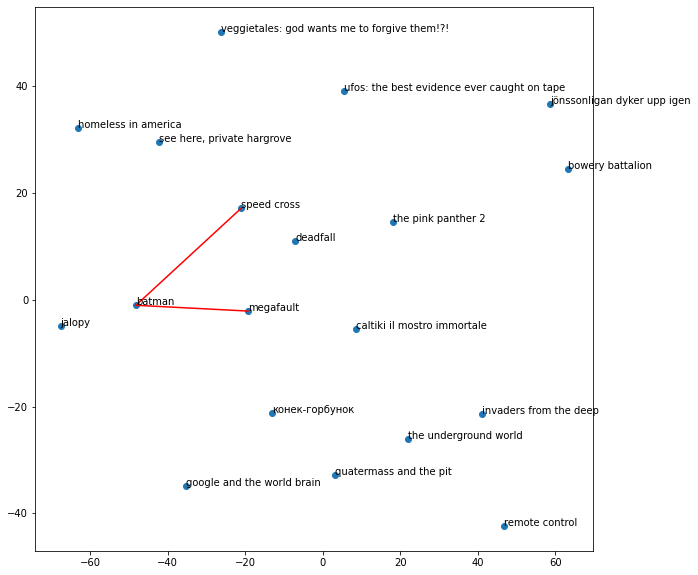

In [ ]:
from pandas.io.formats.printing import format_object_attrs
import matplotlib.pyplot as plt


X, Y = vectors_2d.T
plt.figure(figsize=(10,10))
plt.scatter(X, Y)

for i in range(len(X)):
  plt.annotate(names[i], (X[i], Y[i]))

x, y = X[0], Y[0]
for i in range(1, 3):
  plt.plot([x, X[i]], [y, Y[i]], c ='red')

In [ ]:
def get_recommendations(movie_name, topn = 20):
  global movies_vectors, name_mapper
  movie_id = movies_inv_mapper[movie_name]
  movie_embeddings = movies_vectors[movie_id]
  similars = model.docvecs.most_similar(positive = [movie_embeddings], topn = topn+1)
  output = pd.DataFrame(similars, columns = ['model_index', 'model_score'])
  return  list(output['model_index'].astype(int).map(name_mapper))[1:]

get_recommendations('batman')

['megafault',
 'speed cross',
 'ufos: the best evidence ever caught on tape',
 'homeless in america',
 'the underground world',
 'конек-горбунок',
 nan,
 'see here, private hargrove',
 'jalopy',
 'veggietales: god wants me to forgive them!?!',
 'google and the world brain',
 'caltiki il mostro immortale',
 'bowery battalion',
 'jönssonligan dyker upp igen',
 'remote control',
 'the pink panther 2',
 'invaders from the deep',
 'deadfall',
 'quatermass and the pit',
 'francesco, giullare di dio']

# TODO

- Add `original_title`, `keywords`, `tagline` and other metadata to train sample and then retrain embeddings;
- Make visualization of embeddings with links of films with each other;
- Compare results with the embeddings we created in lecture
- Write function get_recommendations() which takes arguments we used 2.3., but such that we can use embeddings of several watched films to get recommendations

# Appendix

Here, we wrap up all pipeline into functions to re-use if needed and it is just prettier to code this way :)

In [ ]:
def get_clean_tags_array(agg_tags: pd.DataFrame,
                         text_col = 'tag'):
    '''text preprocessing
    '''
    tags_corpus = agg_tags[text_col].values
    tags_corpus = [re.sub('-[!/()0-9]', '', x) for x in tags_corpus]
    stop_words = stopwords.words('english')


    # preprocess corpus of movie tags before feeding it into Doc2Vec model
    tags_doc = [TaggedDocument(words = word_tokenize_clean(D, stop_words), tags = [str(i)]) for i, D in enumerate(tags_corpus)]

    return tags_doc


In [ ]:
def train_embeddings(tags_doc: np.array,
                     epochs = 20,
                     vec_size = 50,
                     alpha = .02,
                     min_alpha =  0.00025,
                     min_count = 5,
                     save_path: str = None):
    """
    fit doc2vec model to prepared corpus
    :tags_doc: result of get_clean_tags_array()
    :max_epocs: int
    :vec_size: int
    :alpha: float
    """
    #initialize
    model = Doc2Vec(vector_size = vec_size,
                    alpha = alpha, 
                    min_alpha = min_alpha,
                    min_count = min_count,
                    dm = 0)
    
    #generate vocab from all tag docs
    model.build_vocab(tags_doc)
    
    #train model
    model.train(tags_doc,
                total_examples = model.corpus_count,
                epochs = epochs)
    
    #save model to dir
    if save_path:
        model.save(f'{save_path}/d2v_model.pkl')
    
    return model